<a href="https://colab.research.google.com/github/josmuniz/Agent-8Puzzle/blob/main/COMP263_G5_Brain_Tumor_Generation_GAN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import cv2
import os
from keras.models import Sequential
from keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, Dropout
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, Dropout

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Initialize lists to store images and labels
X = []
Y = []
# Define directories for the two classes: "no" and "yes"
dirs = ['../content/drive/MyDrive/brain_tumor_dataset/to_train_validate/no','../content/drive/MyDrive/brain_tumor_dataset/to_train_validate/yes']
# Iterate over directories
for i in dirs:
    path = i
    # Iterate over images in each directory
    for x in os.listdir(path):
        # Read, resize, and convert images to grayscale
        img = cv2.imread(path + '/'+ x)
        img = cv2.resize(img,(128, 128), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(128,128,1)
        X.append(img)
        Y.append(i)
# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)
print("Shape of X: ", np.shape(X))
print("Shape of Y: ", np.shape(Y))

Shape of X:  (241, 128, 128, 1)
Shape of Y:  (241,)


In [43]:
# normalize images
X = (X.astype(np.float32) - 127.5)/127.5
# print("Shape of X: ", np.shape(X))
# print("Shape of X: ", X1)
# reshape images
X = X.reshape(X.shape[0], 128*128)
print("Shape of X: ", np.shape(X))


Shape of X:  (241, 16384)


In [44]:
#Building the generator model of the GAN
generator_model = Sequential([
    Dense(256, input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(0.2),
    Reshape((16, 16, 1)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])
# Print summary of the generator model
generator_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 1)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 16, 16, 128)       3200      
 Transpose)                                                      
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 128)      

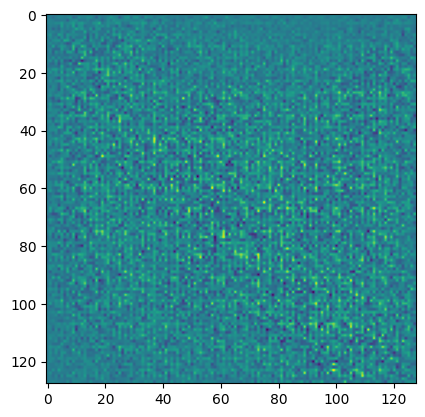

In [45]:
#sample untrained generator
sample_vector = tf.random.normal([1, 100])
sample_image = generator_model(sample_vector, training=False)
plt.imshow(sample_image[0, :, :, 0], cmap='viridis')

In [46]:
#Building the discriminator GAN
discriminator_model = Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(1)
])
# Print summary
discriminator_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1664      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 64, 64, 64)       

In [47]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.legacy.Adam()
discriminator_optimizer = tf.keras.optimizers.legacy.Adam()

def training_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(noise, training=True)
        real_output = discriminator_model(images, training=True)
        fake_output = discriminator_model(generated_images, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))
    return gen_loss, disc_loss

In [36]:
import time
from keras.preprocessing.image import ImageDataGenerator

epochs = 3000
batch_size = 32
gen_loss_history = []
disc_loss_history = []

# Define the image generator
datagen = ImageDataGenerator(
rotation_range=20, # Random rotation range (in degrees)
width_shift_range=0.1, # Random horizontal shift range
height_shift_range=0.1, # Random vertical shift range
shear_range=0.2, # Random shear range
zoom_range=0.2, # Random zoom range
horizontal_flip=True, # Random horizontal flip
fill_mode='nearest' # Fill strategy for pixels outside the original image boundaries
)

# Reshape the data
X = X.reshape(-1, 128, 128, 1)

# Iterator augmented images
augmented_images = datagen.flow(X, batch_size=batch_size)

print("Number of augmented_images: ", augmented_images.n)

Number of augmented_images:  241


In [48]:
# Training with augmented images
for epoch in range(epochs):
    start_time = time.time()
    for i in range(0, len(X), batch_size):
        batch_images = next(augmented_images)
        gen_loss, disc_loss = training_step(batch_images)
        gen_loss_history.append(gen_loss)
        disc_loss_history.append(disc_loss)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))

Time for epoch 1 is 1.8717730045318604 sec
Time for epoch 2 is 1.680311679840088 sec
Time for epoch 3 is 1.6975631713867188 sec
Time for epoch 4 is 1.643007516860962 sec
Time for epoch 5 is 1.6860830783843994 sec
Time for epoch 6 is 1.9984076023101807 sec
Time for epoch 7 is 2.017476797103882 sec
Time for epoch 8 is 1.707970142364502 sec
Time for epoch 9 is 1.7343037128448486 sec
Time for epoch 10 is 1.6854221820831299 sec
Time for epoch 11 is 1.6787245273590088 sec
Time for epoch 12 is 1.6590561866760254 sec
Time for epoch 13 is 1.8617160320281982 sec
Time for epoch 14 is 2.1292874813079834 sec
Time for epoch 15 is 1.7816920280456543 sec
Time for epoch 16 is 1.6117424964904785 sec
Time for epoch 17 is 1.6012370586395264 sec
Time for epoch 18 is 1.5852513313293457 sec
Time for epoch 19 is 1.596235752105713 sec
Time for epoch 20 is 1.5994243621826172 sec
Time for epoch 21 is 1.787019968032837 sec
Time for epoch 22 is 2.021806478500366 sec
Time for epoch 23 is 1.5776104927062988 sec
Time

In [49]:
# Generating 16 sample vectors
sample_vectors = tf.random.normal(shape=(16, 100))

# Generating images from the generator
generated_images = generator_model(sample_vectors, training=False)

# Normalizing the pixels in the generated images
generated_images = (generated_images * 127.5) + 127.5

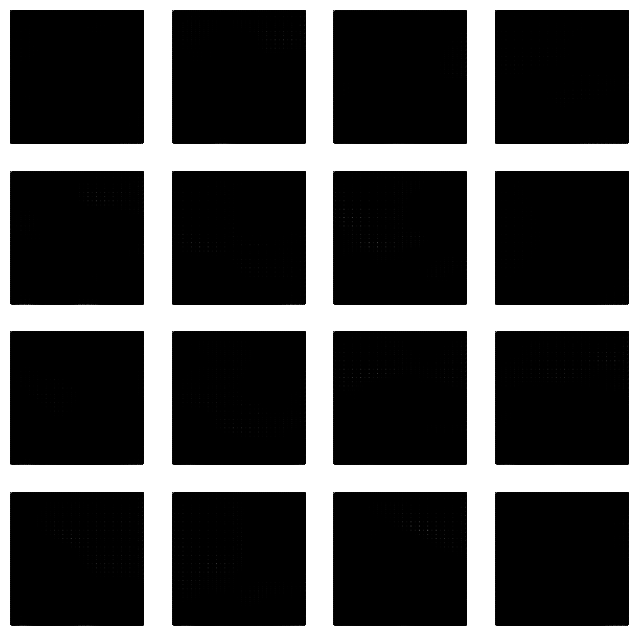

In [50]:
# Plotting the generated images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()
